# Heyoo

This notebook is the companion for the text analysis chapter (7) of the Researching Digital Media and Society" (Lindgren & Eriksson Krutrök, SAGE, 2024)

In this notebook you will find step by step analysis of the Trump Twitter Archive using the methods of 
    - Keyword analysis
    -
    -
    -
    

Before getting started with the notebooks, please run the following steps

1. Open a terminal on your device
2. Clone the project repository
   
   ```
   git clone git clone https://github.com/CousinThrockmorton/Researching-Digital-Media-and-Society.git /where/you/want/it/to/go
   ```
   
4. Navigate to where you cloned the repository
   
   ```
   cd /where_ever/you/put/you/git/cloned/your/repository
   ```
   
6. Create a virtual environment using:
   
   ```
    conda create --name digital_media python=3.10
   ```
   
8. Activate your virtual environment
   
   ```
   conda activate digital_media
   ```
   
10. Install packages required to run the notebooks by running

   ```
   pip install -r requirements.txt
   ```


## Loading libraries and Data

### Loading the libraries used in the analysis
Take note to run pip install -r requirements to install dependencies before running the notebooks

In [1]:
import kagglehub # used to pull the data
import pandas as pd # for managing the dataset
import os # accessing and managing file systems 
import matplotlib.pyplot as plt # creating plots 
import spacy
import re # for regular expression ie. the standard way computers deal with written text
from collections import Counter # different container for managing text 
import gensim # for topic modelling
from gensim import corpora # for the bag of wrods managing the corpora
import math # self explanatory, the inbuilt math functions
import pyLDAvis.gensim_models as gensimvis # for LDA
import pyLDAvis # visualisation of the LDA
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # Sentiment analysis 

/home/boop/anaconda3/envs/digital_media/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading the dataset via the kaggle API

In [2]:
path = kagglehub.dataset_download("headsortails/trump-twitter-archive") # use the kaggle syntax to pull the data
# Alternatively you can download the file from https://www.kaggle.com/datasets/headsortails/trump-twitter-archive
# Unzip the file and put it somewhere sensible like the project directory 
# uncomment this line and fill in your file location file_path = '/location/your_unzipped_dataset'

print("Path to dataset files:", path) # find where kagglehub put the dataset

file_path = os.path.join(path, "trump_tweets.csv") # specific the complete path to the dataset

df = pd.read_csv(file_path) # use the pandas library to open the file as a dataframe
# the index is random, to add some information and make further analysis easier we can set the datetime as the index
df['datetime'] = pd.to_datetime(df['datetime']) #recode datetime as a datetime variable type instead of text
df.set_index('datetime', inplace=True) # set the index to the datetime variable 

100%|██████████████████████████████████████| 4.34M/4.34M [00:00<00:00, 6.10MB/s]

Extracting files...


Path to dataset files: /home/boop/.cache/kagglehub/datasets/headsortails/trump-twitter-archive/versions/1


## Initial exploration and Data cleaning

### Taking a first looks, exploratory analysis of the data

In [3]:
print(f"The dataset contains {df.shape[0]} tweets form Trump")
print(f"Each tweet has a variety of attributes, specifically {list(df.columns)}")

df[['favorites','retweets']].describe() # descriptive statistics for the numeric variables
retweet_counts = df['is_retweet'].value_counts() #descriptive statistics for binary/categorical variables
print(retweet_counts)
df[['is_flagged','is_deleted']].value_counts() # descriptives for the categoricals with cross categories

df.head(5) # take a look at the data

The dataset contains 56571 tweets form Trump
Each tweet has a variety of attributes, specifically ['id', 'text', 'is_retweet', 'is_deleted', 'device', 'favorites', 'retweets', 'is_flagged', 'date']
is_retweet
False    46694
True      9877
Name: count, dtype: int64


,id,text,is_retweet,is_deleted,device,favorites,retweets,is_flagged,date
datetime,,,,,,,,,
2011-08-02 18:07:48+00:00,9.845497e+16,Republicans and Democrats have both created ou...,False,False,TweetDeck,49,255,False,2011-08-02
2020-03-03 01:34:50+00:00,1.234653e+18,I was thrilled to be back in the Great city of...,False,False,Twitter for iPhone,73748,17404,False,2020-03-03
2020-01-17 03:22:47+00:00,1.218011e+18,RT @CBS_Herridge: READ: Letter to surveillance...,True,False,Twitter for iPhone,0,7396,False,2020-01-17
2020-09-12 20:10:58+00:00,1.304875e+18,The Unsolicited Mail In Ballot Scam is a major...,False,False,Twitter for iPhone,80527,23502,False,2020-09-12
2020-01-17 13:13:59+00:00,1.218160e+18,RT @MZHemingway: Very friendly telling of even...,True,False,Twitter for iPhone,0,9081,False,2020-01-17


## Analysis

### Content Analysis
We take a look at the occurance of fake news, you can change the key to anything else 

First off we can create some simple analysis just using some basic regular expression. Regular expression is a powerful tool in text analysis for extracting specific patterns from text data 

In [4]:
# create new variables counting the occurance of a specific phrase within a document(in this case document = one tweet)
df['fake_news_count'] = df["text"].str.lower().str.count(r"fake news") # r prefix lets python know to treat input as string litteral ie. keep the backslashes instead of escaping the next character
df['fake_count'] = df["text"].str.lower().str.count(r"fake") # you can look for different strings or substrings because maybe there are some cases you missed
df['news_count'] = df["text"].str.lower().str.count(r"news")
df['mentions'] = df['text'].str.findall(r'@\w+') # this is a bit more complex regex it looks for all the mentions in the tweets
# it looks for substrings starting with the '@' character matching all the [A-Za-z0-9_] characters after is using '\w' the + means we looks for one or more characters until a non match ie. a white space
# regular expression is a powerful method for extracting information one seeks from unstructured text

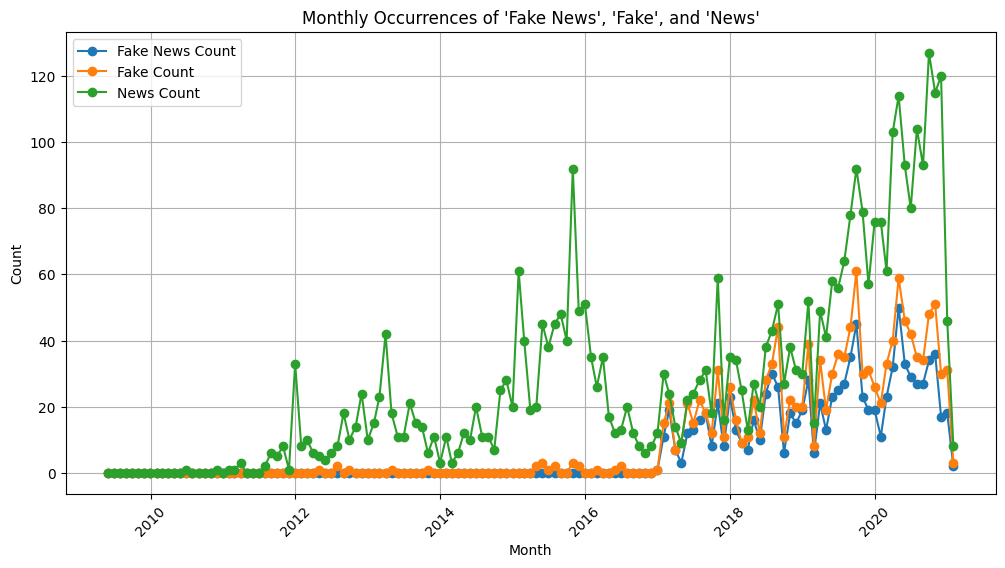

In [5]:
# for plotting the extracted info the granularity of the data is not very useful as daily counts are too granular over years of observations
monthly_counts = df.resample('ME')[['fake_news_count', 'fake_count', 'news_count']].sum().reset_index() # resampling the data for 

# Plot the monthly trends for fake_news_count
plt.figure(figsize=(12, 6)) # initalise the plot 
plt.plot(monthly_counts['datetime'], monthly_counts['fake_news_count'], 
         label="Fake News Count", marker='o', linestyle='-') # add line plots one by one
plt.plot(monthly_counts['datetime'], monthly_counts['fake_count'], 
         label="Fake Count", marker='o', linestyle='-')
plt.plot(monthly_counts['datetime'], monthly_counts['news_count'], 
         label="News Count", marker='o', linestyle='-')

# Formatting the plot
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Monthly Occurrences of 'Fake News', 'Fake', and 'News'")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Breaking things down, Tokenisation

In [6]:
# for this I will write a small function to tokenise each tweet as well as clean up the text 
# Load the small English model
nlp = spacy.load("en_core_web_sm")


def tokenise(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove mentions
    text = re.sub(r"@\w+", "", text)
    # Remove retweet tags
    text = re.sub(r'rt', "", text)
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    # Remove all punctuation and non-alphabetic characters
    text = re.sub(r"[^a-z\s]", "", text)
    
    # Use spaCy to tokenize the cleaned text
    doc = nlp(text)

    return doc # return the entire resulting dictionary so we can take a look at it and reuse it

# Apply the function to your DataFrame column this might take a second
df['tokenised_text'] = df['text'].apply(tokenise)

print("Tokenised texts look like this:",df['tokenised_text'].iloc[1]) 

Tokenised texts look like this: i was thrilled to be back in the great city of charlotte noh carolina with thousands of hardworking american patriots who love our country cherish our values respect our laws and always put america first thank you for a wonderful evening kag 


In [7]:
df['tokenised_text'].iloc[1]

i was thrilled to be back in the great city of charlotte noh carolina with thousands of hardworking american patriots who love our country cherish our values respect our laws and always put america first thank you for a wonderful evening kag 

In [8]:
# There is no straightforward command for concordance analysis in spacy that works with phrases so we need to write one
# Note for tweets it would be easier to simply search for the tweets 
# df['text'][df['text'].str.contains("fake news", case=False)]
def concordance_for_phrase(tokens, phrase=None, window=10):
    
    contexts = [] # output container
    phrase_length = len(phrase) # learn the length of the phrase
    for i in range(len(tokens) - phrase_length + 1): # 
        if tokens[i:i+phrase_length] == phrase:
            # Define context boundaries
            start = max(0, i - window)
            end = min(len(tokens), i + phrase_length + window)
            context = tokens[start:end]
            contexts.append(" ".join(context))
    return contexts

# Then loop through all the tweets 
all_concordances = []
for doc in df['tokenised_text']:
    # Convert the Doc to a list of token texts (ignoring whitespace)
    tokens_list = [token.text for token in doc if not token.is_space]
    contexts = concordance_for_phrase(tokens_list, phrase=["fake", "news"])
    if contexts:
        all_concordances.extend(contexts)

# Print the first 10 concordances
for context in all_concordances[:10]:
    print("-", context)


- fake news reached out for an interview i agreed i let them
- the military a happy thanksgiving realized once again that the fake news media coordinates so that the real message of such a
- leading a hearing on the election fraud they and the fake news working together want to silence the truth ca nt let
- the fake news is talking about cases cases cases this includes many low
- big tech and the fake news media have panered to suppress freedom of the press is
- countries are sadly getting clobbered by the china virus the fake news does not like repoing this
- socalled republican rino is being used big time by the fake news media to explain how honest things were with respect to
- the fake news is not talking about the fact that covid is running
- fake news always forgets to mention that far fewer people are dying
- from the anchor to get him through the interview the fake news cael is working oveime to cover it up


In [9]:
def collocations_for_target(tokens, target, window=3):
    collocations = []
    for i, token in enumerate(tokens):
        if token == target:
            # Determine context window (exclude the target token itself)
            start = max(0, i - window)
            end = min(len(tokens), i + window + 1)
            # Exclude the target token
            context = tokens[start:i] + tokens[i+1:end]
            collocations.extend(context)
    return collocations

# Initialize lists to hold collocations for each target across all tweets
hillary_collocations = []
bernie_collocations = []

for doc in df['tokenised_text']:
    tokens = [token.text for token in doc if not token.is_space]
    hillary_collocations.extend(collocations_for_target(tokens, "hillary"))
    bernie_collocations.extend(collocations_for_target(tokens, "bernie"))

# Count the frequency of collocates
hillary_freq = Counter(hillary_collocations)
bernie_freq = Counter(bernie_collocations)

# Display the 10 most common collocations for each target
print("\nTop 10 collocations for 'hillary':")
for word, count in hillary_freq.most_common(10):
    print(f"{word}: {count}")

print("\nTop 10 collocations for 'bernie':")
for word, count in bernie_freq.most_common(10):
    print(f"{word}: {count}")



Top 10 collocations for 'hillary':
crooked: 364
clinton: 331
the: 170
and: 150
to: 106
is: 91
for: 71
that: 67
a: 61
in: 56

Top 10 collocations for 'bernie':
sanders: 92
crazy: 44
and: 35
the: 33
to: 30
is: 25
with: 14
for: 14
has: 14
of: 12


### Part of Speech tagging and Named entity recognition

For the next steps we need to tokenise the texts this means we break the text up to smaller parts to analyse it as data.

In [10]:
# We can use dictionary comprehension to find all adjectives
adjectives = [token.text.lower() for doc in df['tokenised_text'] for token in doc if token.pos_ == 'ADJ']

# Get the 10 most common adjectives
top_adjectives = Counter(adjectives).most_common(10) # then we can count all the adjectives 
print(top_adjectives)

[('great', 7468), ('big', 2072), ('good', 1759), ('many', 1749), ('new', 1694), ('more', 1587), ('fake', 1266), ('american', 1204), ('best', 1177), ('last', 1087)]


In [11]:
# Extract entities as tuples using comprehensions
entities = [(ent.text, ent.label_) for doc in df['tokenised_text'] for ent in doc.ents]

# Get the 10 most common entities
top_entities = Counter(entities).most_common(10)
print("Top 10 entities (text, label):")
for entity, count in top_entities:
    print(entity, count)


Top 10 entities (text, label):
('democrats', 'NORP') 1830
('today', 'DATE') 1565
('american', 'NORP') 1358
('america', 'GPE') 1234
('china', 'GPE') 1106
('donald trump', 'PERSON') 914
('first', 'ORDINAL') 914
('tonight', 'TIME') 899
('us', 'GPE') 856
('one', 'CARDINAL') 794


### Topic modelling and word Embeding

In [12]:
# Convert each spaCy Doc into a list of tokens 
def unwrap_doc(doc):
    return [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_space]

# Apply the unwrapping function to each tweet
texts_from_doc = df['tokenised_text'].apply(unwrap_doc).tolist()

# Now create the gensim dictionary and corpus
dictionary = corpora.Dictionary(texts_from_doc)
corpus = [dictionary.doc2bow(text) for text in texts_from_doc]


In [13]:
num_topics = 10  # as an example, you can adjust based on your needs
lda_model = gensim.models.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   num_topics=num_topics,
                                   random_state=42,
                                   passes=10)

# Print the topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")


Topic 0: 0.038*"president" + 0.036*"country" + 0.026*"need" + 0.024*"united" + 0.020*"states" + 0.020*"run" + 0.017*"people" + 0.014*"law" + 0.013*"america" + 0.013*"not"
Topic 1: 0.099*"great" + 0.069*"thank" + 0.022*"america" + 0.018*"job" + 0.017*"love" + 0.014*"hunt" + 0.014*"mexico" + 0.014*"witch" + 0.013*"tonight" + 0.013*"good"
Topic 2: 0.065*"vote" + 0.028*"state" + 0.022*"new" + 0.017*"office" + 0.015*"poll" + 0.014*"shutdown" + 0.011*"makeamericagreatagain" + 0.011*"post" + 0.010*"syria" + 0.010*"lead"
Topic 3: 0.068*"amp" + 0.026*"border" + 0.022*"win" + 0.021*"pay" + 0.021*"wall" + 0.016*"democrats" + 0.016*"big" + 0.015*"country" + 0.015*"not" + 0.015*"want"
Topic 4: 0.037*"new" + 0.034*"great" + 0.028*"hillary" + 0.025*"look" + 0.023*"house" + 0.022*"clinton" + 0.019*"work" + 0.017*"forward" + 0.017*"white" + 0.017*"family"
Topic 5: 0.031*"not" + 0.017*"know" + 0.017*"president" + 0.016*"say" + 0.014*"collusion" + 0.013*"russia" + 0.013*"obama" + 0.013*"impeachment" + 0.

In [16]:
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

#Not that the plots are labeled PC1 and PC2 for principal component one and two 
# This is a mapping from the multidimensional vector space via principal component analysis, that is selecting the hyperplanes that best seperate the data

### Sentiment analysis

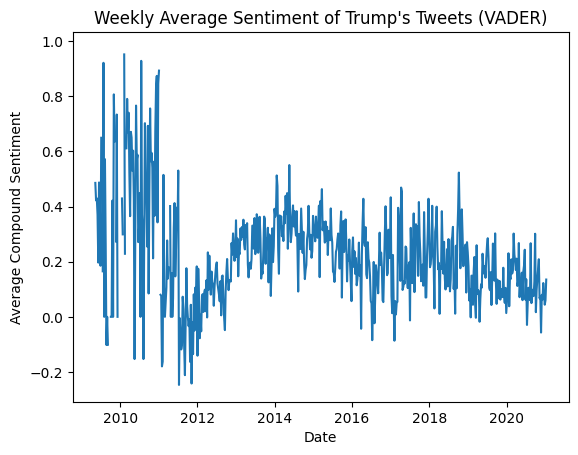

In [15]:
analyzer = SentimentIntensityAnalyzer() # load the function

def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return scores  # this returns a dict with 'neg', 'neu', 'pos', and 'compound'

df['sentiment'] = df['text'].apply(get_sentiment) # again we use apply to run through the whole 
# For example, extract the compound score
df['compound'] = df['sentiment'].apply(lambda x: x['compound'])

# Plot weekly average sentiment over time
weekly_sentiment = df['compound'].resample('W').mean()
plt.plot(weekly_sentiment.index, weekly_sentiment.values)
plt.xlabel("Date")
plt.ylabel("Average Compound Sentiment")
plt.title("Weekly Average Sentiment of Trump's Tweets (VADER)")
plt.show()
